In [1]:
# Load our training data
import json
import random
import numpy
with open("data/ner_train.json") as f:
    data=json.load(f)
print(data[0])

# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["tags"] for one_example in data] # This is now a list of lists just like the texts variable
print(texts[:2])
print(labels[:2])

# Lets do the same thing for the validation data
# We use a separate validation set, since generally using sentences from the same documents as train/validation results in overly optimistic scores
with open("data/ner_test.json") as f:
    validation_data=json.load(f)
validation_texts=[one_example["text"] for one_example in validation_data]
validation_labels=[one_example["tags"] for one_example in validation_data]

{'text': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}
[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]
[['I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['I-PER', 'I-PER']]


In [2]:
# Use gensim to read the embedding model

from gensim.models import KeyedVectors

vector_model=KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=50000)

# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

# Normalize the vectors

print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

# Build vocabulary mappings

vocabulary={"<SPECIAL>": 0, "<OOV>": 1} # zero has a special meaning in sequence models, prevent using it for a normal word
for word in words:
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary

# Label mappings
label_set = set([label for sentence_labels in labels for label in sentence_labels])
label_map = {label: index for index, label in enumerate(label_set)}
                
# Embedding matrix

def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]
Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


In [3]:
import numpy

def vectorizer(vocab, texts, label_map, labels=None):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    vectorized_labels = [] # same thing for the labels
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(texts):
        vectorized_example = []
        vectorized_example_labels = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens
        if labels:
            for label in labels[i]:
                vectorized_example_labels.append(label_map[label])

        vectorized_data.append(vectorized_example)
        vectorized_labels.append(vectorized_example_labels)
        
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy matrix
    vectorized_labels = numpy.array(vectorized_labels)
    
    return vectorized_data, vectorized_labels, sentence_lengths

vectorized_data, vectorized_labels, lengths=vectorizer(vocabulary, texts, label_map, labels)
validation_vectorized_data, validation_vectorized_labels, validation_lengths=vectorizer(vocabulary, validation_texts, label_map, validation_labels)

In [4]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post', maxlen=max(lengths))
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=numpy.expand_dims(pad_sequences(vectorized_labels, padding='post', maxlen=max(lengths)), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
print(label_map)
print("First example labels:", vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:", weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='post', maxlen=max(lengths))
validation_vectorized_labels_padded=numpy.expand_dims(pad_sequences(validation_vectorized_labels, padding='post', maxlen=max(lengths)), -1)
validation_weights = numpy.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

/home/tuomas/virtualenvs/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Old shape: (14041,)
New shape: (14041, 113)
First example: [ 1587 11424   718   537     7 10975   379 14078     4     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
Padded labels shape: (14041, 113, 1)
{'I-ORG': 0, 'I-PER': 1, 'I-LOC': 2, 'O': 3}
First example labels: [[0]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0

In [5]:
import keras

def evaluate(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    try:
        precision = tp / pred_count
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))


def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    
    return entity_offsets

class EvaluateEntities(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluate(pred, validation_vectorized_labels_padded, validation_lengths)

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, Conv1D, TimeDistributed, LSTM, Bidirectional, MaxPooling1D
from keras.optimizers import SGD, Adam

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)

vector_size= pretrained.shape[1]

## Dense

In [ ]:
inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False)(inp)
hidden = TimeDistributed(Dense(100, activation="softmax"))(embeddings)
outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
model=Model(inputs=[inp], outputs=[outp])

lr_dense=0.1
batch_size_dense=100
epochs_dense=100

optimizer=Adam(lr=lr_dense) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

print(model.summary())

# train
hist_dense=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=batch_size_dense,verbose=1,epochs=epochs_dense, callbacks=[EvaluateEntities()])

In [16]:
predicted=model.predict(validation_vectorized_data_padded)

In [11]:
import matplotlib.pyplot as plt

Learning rate: 0.1, Batch size: 100, Epochs: 100


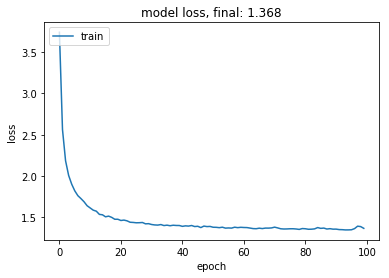

In [12]:
print('Learning rate: {}, Batch size: {}, Epochs: {}'.format(lr_dense, batch_size_dense, epochs_dense))
plt.plot(hist_dense.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss, final: {}'.format(round(hist_dense.history['loss'][-1], 3)))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CNN

In [15]:
inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
cnn = Conv1D(100,3, activation='relu', padding='same')(embeddings)
#cnn1 = Conv1D(100,3, activation='relu', padding='same')(inp)
#dense=TimeDistributed(Dense(class_count, activation="softmax"))(cnn)
#cnn2=Conv1D(100,3, activation='relu', padding='same')(dense)
outp=TimeDistributed(Dense(class_count, activation="softmax"))(cnn)
model_cnn=Model(inputs=[inp], outputs=[outp])

lr_cnn=0.001
batch_size_cnn=100
epochs_cnn=100

optimizer=Adam(lr=lr_cnn) # define the learning rate
model_cnn.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

# This is our model for outputting the time step wise kernel activations.
cnn_out_model=Model(inputs=[inp], outputs=[cnn])
# We have to compile the model, but we nerver train it directly
cnn_out_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",sample_weight_mode='temporal')

print(model.summary())

# train
hist_cnn=model_cnn.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=batch_size_cnn,verbose=1,epochs=epochs_cnn, callbacks=[EvaluateEntities()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 113, 300)          15000600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 113, 100)          160400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 4)            404       
Total params: 15,161,404
Trainable params: 160,804
Non-trainable params: 15,000,600
_________________________________________________________________
None
Epoch 1/100
14041/14041 [==============================] - 1s 61us/step - loss: 0.4009

Precision/Recall/F-score: 0.7028242939265184 / 0.5601593625498008 / 0.6234342090677308
Epoch 2/100
14041/14041 [==============================] - 1s 46us/step - lo

14041/14041 [==============================] - 1s 46us/step - loss: 0.0526

Precision/Recall/F-score: 0.7876685934489402 / 0.8143426294820717 / 0.8007835455435847
Epoch 44/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0521

Precision/Recall/F-score: 0.8033582844426461 / 0.7910358565737052 / 0.7971494529760113
Epoch 45/100
14041/14041 [==============================] - 1s 47us/step - loss: 0.0518

Precision/Recall/F-score: 0.8070564516129032 / 0.797410358565737 / 0.8022044088176353
Epoch 46/100
14041/14041 [==============================] - 1s 47us/step - loss: 0.0511

Precision/Recall/F-score: 0.8065619967793881 / 0.7982071713147411 / 0.802362835402483
Epoch 47/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0510

Precision/Recall/F-score: 0.8135523613963039 / 0.7892430278884462 / 0.8012133468149646
Epoch 48/100
14041/14041 [==============================] - 1s 44us/step - loss: 0.0504

Precision/Recall/F-score: 0.809668284789644 / 

14041/14041 [==============================] - 1s 46us/step - loss: 0.0398

Precision/Recall/F-score: 0.7871116225546605 / 0.8175298804780876 / 0.80203244088333
Epoch 91/100
14041/14041 [==============================] - 1s 44us/step - loss: 0.0396

Precision/Recall/F-score: 0.783957623912221 / 0.8254980079681274 / 0.8041917329710847
Epoch 92/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0399

Precision/Recall/F-score: 0.7945505171042164 / 0.795816733067729 / 0.7951831210191083
Epoch 93/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0395

Precision/Recall/F-score: 0.7907425265188043 / 0.8167330677290837 / 0.8035276825085742
Epoch 94/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0393

Precision/Recall/F-score: 0.7855495772482706 / 0.8143426294820717 / 0.7996870109546167
Epoch 95/100
14041/14041 [==============================] - 1s 46us/step - loss: 0.0394

Precision/Recall/F-score: 0.7935333073626801 / 0

In [16]:
input_data=validation_vectorized_data_padded
predictions=cnn_out_model.predict(input_data, verbose=1)
print("Predictions shape:", predictions.shape)

3250/3250 [==============================] - 0s 86us/step
Predictions shape: (3250, 113, 100)


In [9]:
window_size=3


word_embeddings = model.layers[1].get_weights()[0]
print("Word embeddings from the model:", word_embeddings.shape)
print("Kernels:", model.layers[2].get_weights()[0].shape)
for kernel_index in range(model.layers[2].get_weights()[0].shape[-1]):
    kernel = model.layers[2].get_weights()[0][:,:,kernel_index] + model.layers[2].get_weights()[1][kernel_index]

    # Hypothetical highest activations
    activations = numpy.dot(kernel, word_embeddings.T)
    best_word_indices = numpy.argmax(activations, axis=-1)
    
    # Highest activations seen in the validation data
    max_time_steps = numpy.argmax(predictions[:,:,kernel_index], axis=-1)
    max_activations = numpy.max(predictions[:,:,kernel_index], axis=-1)
    best_sentences = numpy.argsort(-max_activations)
    
    best_ngrams = [input_data[best_sentences[nth]][max_time_steps[best_sentences[nth]]:max_time_steps[best_sentences[nth]]+window_size] for nth in range(10)]
    best_ngrams = [' '.join([inversed_vocabulary[i] for i in best]) for best in best_ngrams]
    best_ngrams = ' | '.join(best_ngrams)
 
    print('Kernel %s:' % kernel_index)
    print(best_ngrams)
    print('Hypothetical maximum activation %s:' % kernel_index, ' '.join([inversed_vocabulary[wi] for wi in best_word_indices]), numpy.max(activations, axis=-1), '\n')

Word embeddings from the model: (50002, 300)
Kernels: (3, 300, 100)
Kernel 0:
<OOV> - <OOV> | <OOV> <OOV> <SPECIAL> | Canada beat Panama | <OOV> : <SPECIAL> | Canada - <OOV> | Panama - Jorge | Attendance : <OOV> | <OOV> <OOV> - | Andy <OOV> <SPECIAL> | <OOV> <OOV> <SPECIAL>
Hypothetical maximum activation 0: lastname postcode postcode [0.27328673 0.28709066 0.25920066] 

Kernel 1:
WITH <OOV> IN | Vale 4 1 | Standard <OOV> on | Royals 4-0 . | winger <OOV> <OOV> | Vale 2 Oxford | Rovers 1 Stockport | Rovers 3 1 | City 0 <SPECIAL> | midfielder <OOV> .
Hypothetical maximum activation 1: mappings Maroons 0 [5.6020603 3.7769701 3.0427697] 

Kernel 2:
said his mother | had taken a | greatest gift to | said 20-year-old Ali | Bob Kennedy ( | Mohammed Idris . | said economist Lynn | had seized two | Aziz said in | said Rios .
Hypothetical maximum activation 2: ATF Abdallah Winfrey [2.8304188 3.6919897 2.7543094] 

Kernel 3:
general corporate purposes | own currency , | his family is | own territ

Kernel 28:
allowing a hit | leader Aslan <OOV> | leader Aslan <OOV> | leader Aslan <OOV> | yielding a single | after the break | after the break | arrested the militants | said a few | where a majority
Hypothetical maximum activation 28: foreigner king brand-new [5.297423  5.355601  4.0663314] 

Kernel 29:
<OOV> <SPECIAL> <SPECIAL> | <OOV> <SPECIAL> <SPECIAL> | <OOV> <SPECIAL> <SPECIAL> | <OOV> <SPECIAL> <SPECIAL> | <OOV> <SPECIAL> <SPECIAL> | <OOV> <SPECIAL> <SPECIAL> | <SPECIAL> <SPECIAL> <SPECIAL> | <SPECIAL> <SPECIAL> <SPECIAL> | <OOV> 4 2 | <OOV> - <OOV>
Hypothetical maximum activation 29: Referencing VIDEO VIDEO [0.27015433 0.26864776 0.26402205] 

Kernel 30:
agreement " shall | Olympic champion Lindsay | prefix number denotes | prefix number denotes | prefix number denotes | prefix number denotes | markets weakened after | demonstrations by students | demonstrations by students | telecoms group LM
Hypothetical maximum activation 30: Minister licences introduction [6.0437584 5.45

Kernel 64:
( Australia ) | b Gough 0 | ( Ireland ) | ) <SPECIAL> <SPECIAL> | : Sussex 363 | : Sussex 363 | ) <SPECIAL> <SPECIAL> | ( Australia ) | ( 2nd minute | ( Ireland )
Hypothetical maximum activation 64: quilts Drivers Collector [5.6926985 4.4995947 5.215971 ] 

Kernel 65:
<OOV> Aziz said | Mohammed Idris . | Chris Lewis , | C. Lewis 80 | C. Lewis 94 | 20-year-old Ali Ahmed | be replaced by | <OOV> wa <OOV> | of Islam group | president Mohamed <OOV>
Hypothetical maximum activation 65: Minister Hariri Idris [4.462101  3.0111177 5.032946 ] 

Kernel 66:
6 - 2 | the final day | 386 - $ | Monday due to | day I 've | jump competition at | 418 - $ | live in peace | day . <SPECIAL> | number denotes seeding
Hypothetical maximum activation 66: zip M6 proofreading [5.510318  3.4981873 4.8146358] 

Kernel 67:
Ali Ahmed from | Anthony Washington ( | Gough 33 <SPECIAL> | Armando Alvarez was | Ponting not out | Bevan allowed Van | Anthony Hill ( | Fleming 44 <SPECIAL> | Rhodes 57 ; | Duran stil

Learning rate: 0.01, Batch size: 100, Epochs: 100


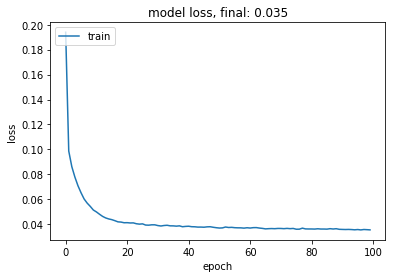

In [12]:
print('Learning rate: {}, Batch size: {}, Epochs: {}'.format(lr_cnn, batch_size_cnn, epochs_cnn))
plt.plot(hist_cnn.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss, final: {}'.format(round(hist_cnn.history['loss'][-1], 3)))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## LSTM

In [13]:
inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
rnn = LSTM(100, activation='tanh', return_sequences=True)(embeddings)
outp=TimeDistributed(Dense(class_count, activation="softmax"))(rnn)
model=Model(inputs=[inp], outputs=[outp])

lr_lstm=0.1
batch_size_lstm=100
epochs_lstm=100

optimizer=Adam(lr=lr_lstm) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

print(model.summary())

# train
hist_lstm=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=batch_size_lstm,verbose=1,epochs=epochs_lstm, callbacks=[EvaluateEntities()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 113, 300)          15000600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 113, 100)          160400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 4)            404       
Total params: 15,161,404
Trainable params: 160,804
Non-trainable params: 15,000,600
_________________________________________________________________
None
Epoch 1/100
14041/14041 [==============================] - 27s 2ms/step - loss: 4.6544

Precision/Recall/F-score: 0.5072115384615384 / 0.04203187250996016 / 0.07763061074319352
Epoch 2/100
14041/14041 [==============================] - 27s 2ms/step - 

14041/14041 [==============================] - 27s 2ms/step - loss: 0.7082

Precision/Recall/F-score: 0.7523830636222567 / 0.6760956175298805 / 0.7122022872731089
Epoch 44/100
14041/14041 [==============================] - 27s 2ms/step - loss: 0.7151

Precision/Recall/F-score: 0.7079789388416363 / 0.6964143426294821 / 0.7021490259088171
Epoch 45/100
14041/14041 [==============================] - 27s 2ms/step - loss: 0.7413

Precision/Recall/F-score: 0.7397660818713451 / 0.7055776892430279 / 0.7222675367047308
Epoch 46/100
14041/14041 [==============================] - 27s 2ms/step - loss: 0.6989

Precision/Recall/F-score: 0.7035196687370601 / 0.6768924302788845 / 0.6899492385786802
Epoch 47/100
14041/14041 [==============================] - 27s 2ms/step - loss: 1.3668

Precision/Recall/F-score: 0.6510753810816454 / 0.6211155378486056 / 0.6357426852890202
Epoch 48/100
14041/14041 [==============================] - 27s 2ms/step - loss: 1.1855

Precision/Recall/F-score: 0.6769709543568465

14041/14041 [==============================] - 27s 2ms/step - loss: 3.1773

Precision/Recall/F-score: 0.3263888888888889 / 0.24342629482071712 / 0.27886809675947055
Epoch 91/100
14041/14041 [==============================] - 27s 2ms/step - loss: 3.2303

Precision/Recall/F-score: 0.4186284544524053 / 0.16294820717131475 / 0.2345856036707772
Epoch 92/100
14041/14041 [==============================] - 27s 2ms/step - loss: 3.2202

Precision/Recall/F-score: 0.3221476510067114 / 0.24860557768924302 / 0.2806386327861479
Epoch 93/100
14041/14041 [==============================] - 27s 2ms/step - loss: 3.3015

Precision/Recall/F-score: 0.48444444444444446 / 0.13027888446215138 / 0.2053375196232339
Epoch 94/100
14041/14041 [==============================] - 27s 2ms/step - loss: 3.4442

Precision/Recall/F-score: 0.5187319884726225 / 0.10756972111553785 / 0.17818841775284608
Epoch 95/100
14041/14041 [==============================] - 27s 2ms/step - loss: 3.5732

Precision/Recall/F-score: 0.38354898

Learning rate: 0.1, Batch size: 100, Epochs: 100


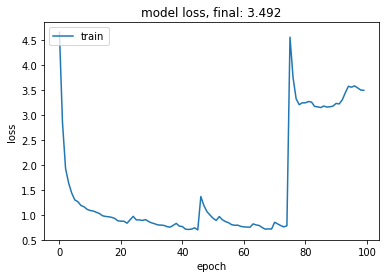

In [14]:
print('Learning rate: {}, Batch size: {}, Epochs: {}'.format(lr_lstm, batch_size_lstm, epochs_lstm))
plt.plot(hist_lstm.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss, final: {}'.format(round(hist_lstm.history['loss'][-1], 3)))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Bidirectional LSTM

In [19]:
inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
rnn = Bidirectional(LSTM(100, activation='tanh', return_sequences=True))(embeddings)
outp=TimeDistributed(Dense(class_count, activation="softmax"))(rnn)
model=Model(inputs=[inp], outputs=[outp])

lr_bilstm=0.1
batch_size_bilstm=100
epochs_bilstm=50

optimizer=Adam(lr=lr_bilstm) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

print(model.summary())

# train
hist_bilstm=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=batch_size_bilstm,verbose=1,epochs=epochs_bilstm, callbacks=[EvaluateEntities()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 113, 300)          15000600  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 113, 200)          320800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 113, 4)            804       
Total params: 15,322,204
Trainable params: 321,604
Non-trainable params: 15,000,600
_________________________________________________________________
None
Epoch 1/50
14041/14041 [==============================] - 53s 4ms/step - loss: 3.4025

Precision/Recall/F-score: 0.6793907484016548 / 0.7197211155378486 / 0.6989746566066938
Epoch 2/50
14041/14041 [==============================] - 52s 4ms/step - loss

14041/14041 [==============================] - 52s 4ms/step - loss: 0.5423

Precision/Recall/F-score: 0.7516495601173021 / 0.8169322709163347 / 0.7829324169530355
Epoch 44/50
14041/14041 [==============================] - 52s 4ms/step - loss: 0.5145

Precision/Recall/F-score: 0.801679983609916 / 0.7794820717131474 / 0.7904252095747903
Epoch 45/50
14041/14041 [==============================] - 52s 4ms/step - loss: 0.5343

Precision/Recall/F-score: 0.7735482617984074 / 0.7934262948207171 / 0.7833611957911298
Epoch 46/50
14041/14041 [==============================] - 52s 4ms/step - loss: 0.5108

Precision/Recall/F-score: 0.7973568281938326 / 0.7932270916334662 / 0.7952865987617335
Epoch 47/50
14041/14041 [==============================] - 52s 4ms/step - loss: 0.6098

Precision/Recall/F-score: 0.7657077971233913 / 0.8059760956175299 / 0.7853260869565216
Epoch 48/50
14041/14041 [==============================] - 52s 4ms/step - loss: 0.6448

Precision/Recall/F-score: 0.7329629629629629 / 0.7

In [2]:
print('Learning rate: {}, Batch size: {}, Epochs: {}'.format(lr_bilstm, batch_size_bilstm, epochs_bilstm))
plt.plot(hist_bilstm.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss, final: {}'.format(round(hist_bilstm.history['loss'][-1], 3)))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'lr_bilstm' is not defined

In [42]:
inverse_label_map = {value: key for key, value in label_map.items()}

def tag_sentence(sentence):
    tokens = sentence.split() # Stupid whitespace tokenization
    vectorized_sentence, _, sentence_length=vectorizer(vocabulary, [tokens], label_map) # Using our global variables again...
    vectorized_sentence_padded = pad_sequences(vectorized_sentence, padding='post', maxlen=max(lengths)) # Pad the sequence

    predictions = model.predict(vectorized_sentence_padded)[0] # Everything so far has been a 'list' of sentences with a single sentence, so we only take index 0
    predictions = numpy.argmax(predictions, axis=-1) # Take the tag index with the highest value for each token
    
    tags = [inverse_label_map[label_index] for label_index in predictions[:len(tokens)]] # Ignore padded region
    return tags, tokens
    
while True:
    sentence=input("sentence> ")
    if sentence=="end":
        break
    tags, tokens = tag_sentence(sentence)
    for token, tag in zip(tokens, tags):
        print(token, tag)

sentence> Thomas
Thomas I-PER
sentence> London
London I-LOC
sentence> Finland
Finland I-LOC
sentence> Microsoft
Microsoft I-ORG
sentence> Turku
Turku I-ORG
sentence> Nokia
Nokia I-ORG
sentence> Apple
Apple I-ORG
sentence> Google
Google O
sentence> Hello hows it going
Hello O
hows I-PER
it O
going O
sentence> Democrats were increasingly optimistic that they had pushed their favored candidates into the general election in several important races in Southern California
Democrats O
were O
increasingly O
optimistic O
that O
they O
had O
pushed O
their O
favored O
candidates O
into O
the O
general O
election O
in O
several O
important O
races O
in O
Southern I-LOC
California I-LOC
sentence> Southern
Southern I-ORG
sentence> Gavin Newsom, a Democratic former mayor of San Francisco, and John Cox, a Republican backed by President Trump, won the two spots in the race to succeed Gov. Jerry Brown
Gavin I-PER
Newsom, I-PER
a O
Democratic O
former O
mayor O
of O
San I-LOC
Francisco, I-LOC
and O
John

KeyboardInterrupt: 